<a href="https://colab.research.google.com/github/Ivan123yoo/Unsupervised_Land_Cover_Classification_Sentinel2/blob/main/Unsupervised_Land_Cover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Land Cover Classification Using Unsupervised Learning

---



Unsupervised Land Cover Classification Using NDVI, NDWI, SWI, and K-Means Clustering
Introduction:
This project explores unsupervised land cover classification in two contrasting regions: the Mississippi Delta and Patagonia. The analysis applies three methods—NDWI (Normalized Difference Water Index), SWI (Spectral Water Index), and K-Means Clustering—to accurately identify water, vegetation, and bare land. The aim is to compare the performance of these methods, assessing their effectiveness in capturing water bodies and other land types. By examining these methods in diverse environments, this study provides insights into the strengths and limitations of each approach, offering a clear understanding of their suitability for different geographic contexts.

## Problem Statement: Unsupervised Land Cover Classification

This project focuses on classifying land cover in two contrasting regions — the Mississippi Delta and Patagonia — using Sentinel-2 satellite imagery. The objective is to apply unsupervised machine learning techniques, specifically NDVI (Normalized Difference Vegetation Index), SWI (Spectral Water Index), and K-Means clustering, to distinguish between various surface features, including water bodies, vegetation, and land surfaces.

Sentinel-2 imagery of Mississippi and Patagonia is used to explore the effectiveness of these methods. The project aims to identify vegetation density with NDVI, detect water bodies with SWI, and categorize land cover types without labeled data using K-Means clustering. This approach offers a scalable solution for monitoring land cover dynamics in diverse environments.



Mount the google drive by running this cell

In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Importing Required Libraries

This section begins by importing the necessary libraries for analysis:

- **rasterio**: For reading, writing, and manipulating geospatial raster data, enabling efficient loading of Sentinel-2 image bands.
- **numpy**: For numerical operations and array manipulations.
- **matplotlib**: For creating and customizing plots, including NDVI and NDWI visualizations.
- **sklearn (scikit-learn)**: For scaling data and applying K-means clustering.
- **os**: For interacting with the operating system, primarily for file management.

The command `!pip install rasterio --quiet` ensures that the rasterio library is installed, especially useful in cloud environments like Google Colab, where packages may need to be reinstalled each session.


In [2]:
# Install rasterio to read geospatial raster data
!pip install rasterio --quiet

# Imports
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 103.9 MB/s eta 0:00:00


### Loading and Displaying RGB Images

In this section, we begin by loading two RGB images: one for the Mississippi region and another for Patagonia. These images were specifically chosen because they represent two contrasting environments — the Mississippi River Delta, a densely vegetated, highly dynamic coastal region, and Patagonia, a mountainous, forested area with a complex landscape. This contrast allows for a more comprehensive evaluation of our classification techniques.

We use the `load_image` function to read the images using the `PIL` library, converting them to RGB format for consistency. This conversion ensures that the images are correctly displayed and that the pixel values are compatible with our NDVI and clustering calculations later in the workflow.

The images are then displayed side by side, allowing us to visually confirm that the correct regions have been loaded and are ready for further analysis. This visual check is essential before proceeding with NDVI and clustering operations allowing us to avoid mistakes.


In [3]:
from PIL import Image

def load_image(path):
    img = Image.open(path).convert('RGB')
    img_array = np.array(img)
    return img_array

# Load both images
Patagonia_path = "/content/drive/MyDrive/AL4EO/final /2025-04-11-00_00_2025-04-11-23_59_Sentinel-2_L2A_True_color.jpg"
Mississipi_path = "/content/drive/MyDrive/AL4EO/final /2025-04-06-00_00_2025-04-06-23_59_Sentinel-2_L2A_True_color-2.jpg"

Mississippi_img = load_image(Mississipi_path)
Patagonia_img = load_image(Patagonia_path)

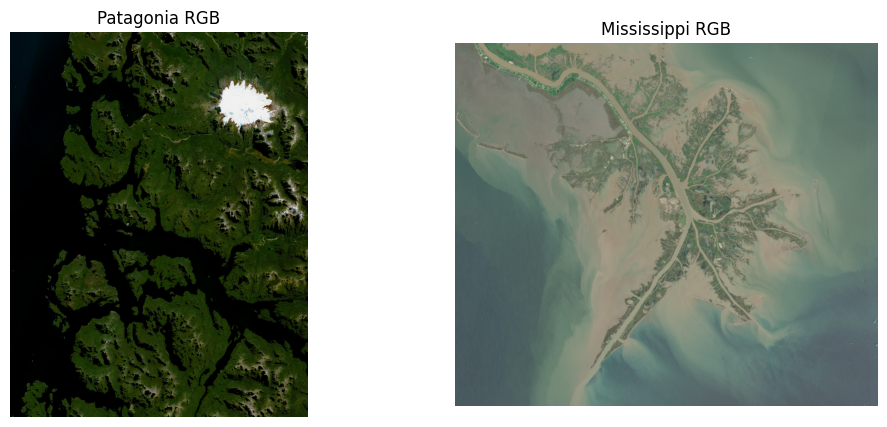

In [4]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(Mississippi_img)
plt.title("Patagonia RGB")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(Patagonia_img)
plt.title("Mississippi RGB")
plt.axis("off")
plt.show()

## NDVI Calculation and Visualization

The Normalized Difference Vegetation Index (NDVI) is a widely used remote sensing index for assessing vegetation health and density. It is calculated using the formula:



$$
NDVI = \frac{\mathrm{NIR} - \mathrm{Red}}{\mathrm{NIR} + \mathrm{Red}}
$$


NIR (Near-Infrared) reflects strongly in healthy vegetation, while Red is absorbed by chlorophyll. NDVI values range from -1 to +1, with higher values indicating dense vegetation and lower values representing bare ground or water.

NDVI was applied to Mississippi and Patagonia. Mississippi shows dense vegetation (dark green) along riverbanks, while water is light green to yellow. Patagonia clearly distinguishes forested areas (green) from barren regions (light).

RGB images were processed using NIR and Red bands, with results visualized on a color scale (-1 to +1).


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


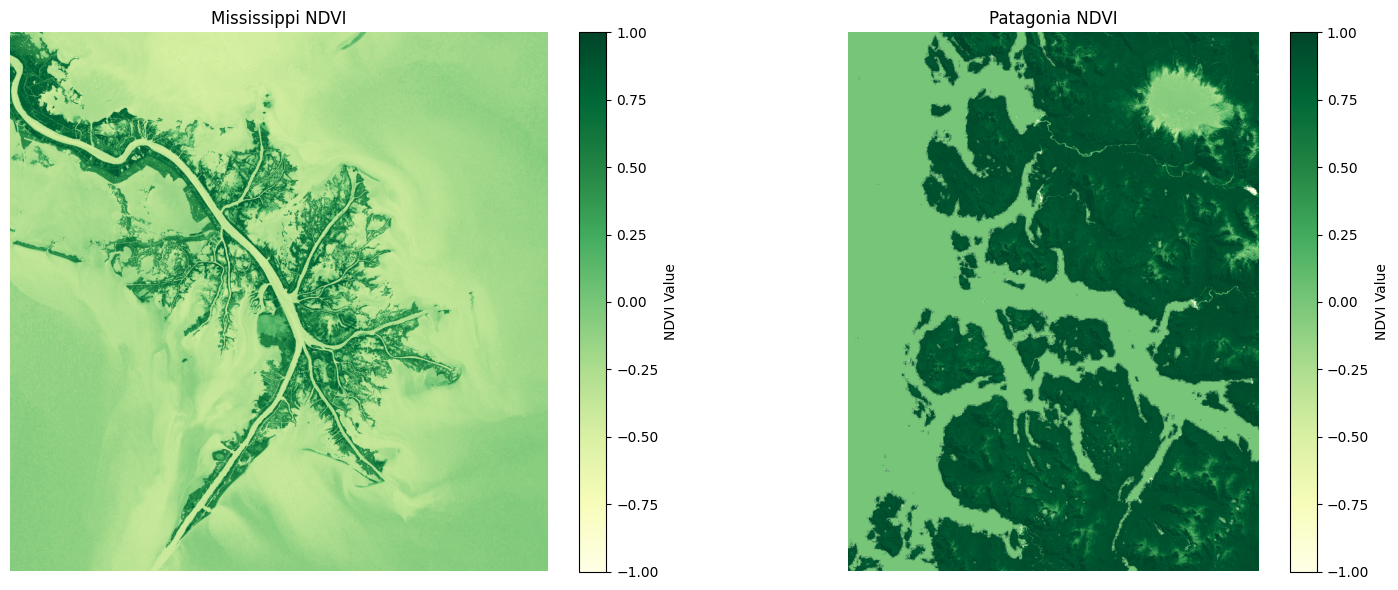

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# NDVI Calculation Function
def calculate_ndvi(image, red_idx=0, nir_idx=1):
    """
    Calculate NDVI from an image using specified Red and NIR bands.

    Parameters:
        image (numpy array): The input image as a numpy array (Bands, Height, Width).
        red_idx (int): The index of the Red band.
        nir_idx (int): The index of the NIR band.

    Returns:
        numpy array: The calculated NDVI image.
    """
    red = image[red_idx, :, :].astype(float)
    nir = image[nir_idx, :, :].astype(float)

    # Avoid division by zero using a small constant
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

# Load Mississippi and Patagonia images (Directly using B04 and B08)
Mississippi_red_path = '/content/drive/MyDrive/AL4EO/final /Mississipi bands/2025-04-11-00:00_2025-04-11-23:59_Sentinel-2_L2A_B04_(Raw).jpg'  # Red Band (B04)
Mississippi_nir_path = '/content/drive/MyDrive/AL4EO/final /Mississipi bands/2025-04-11-00:00_2025-04-11-23:59_Sentinel-2_L2A_B08_(Raw).jpg'  # NIR Band (B08)

Patagonia_red_path = '/content/drive/MyDrive/AL4EO/final /south chilean patagonia bands/Browser_images-7/2025-04-06-00:00_2025-04-06-23:59_Sentinel-2_L2A_B04_(Raw).jpg'     # Red Band (B04)
Patagonia_nir_path = '/content/drive/MyDrive/AL4EO/final /south chilean patagonia bands/Browser_images-7/2025-04-06-00:00_2025-04-06-23:59_Sentinel-2_L2A_B08_(Raw).jpg'     # NIR Band (B08)

# Reading the bands directly
with rasterio.open(Mississippi_red_path) as src:
    Mississippi_red = src.read(1)

with rasterio.open(Mississippi_nir_path) as src:
    Mississippi_nir = src.read(1)

with rasterio.open(Patagonia_red_path) as src:
    Patagonia_red = src.read(1)

with rasterio.open(Patagonia_nir_path) as src:
    Patagonia_nir = src.read(1)

# Stacking them to match the NDVI function structure
Mississippi_image = np.stack([Mississippi_red, Mississippi_nir])
Patagonia_image = np.stack([Patagonia_red, Patagonia_nir])

# Calculating NDVI for Mississippi and Patagonia
Mississippi_ndvi = calculate_ndvi(Mississippi_image, red_idx=0, nir_idx=1)
Patagonia_ndvi = calculate_ndvi(Patagonia_image, red_idx=0, nir_idx=1)

# Plotting NDVI Side by Side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Mississippi NDVI
ndvi_plot1 = axes[0].imshow(Mississippi_ndvi, cmap='YlGn', vmin=-1, vmax=1)
axes[0].set_title("Mississippi NDVI")
axes[0].axis('off')
cbar1 = plt.colorbar(ndvi_plot1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label("NDVI Value")

# Patagonia NDVI
ndvi_plot2 = axes[1].imshow(Patagonia_ndvi, cmap='YlGn', vmin=-1, vmax=1)
axes[1].set_title("Patagonia NDVI")
axes[1].axis('off')
cbar2 = plt.colorbar(ndvi_plot2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label("NDVI Value")

plt.tight_layout()
plt.show()


## Normalized Difference Water Index (NDWI)

The Normalized Difference Water Index (NDWI) is a remote sensing technique used to identify water bodies in satellite imagery. It is calculated using the formula:

$$
\text{NDWI} = \frac{\text{Green - NIR}}{\text{Green + NIR}}
$$

In this calculation, Green (B03) reflects visible light absorbed by water but reflected by vegetation, while NIR (B08) reflects near-infrared light, which is absorbed by water but reflected by vegetation. NDWI was applied using Sentinel-2 data (Band 03 for Green and Band 08 for NIR) to the Mississippi region.

NDWI values range from -1 to +1, where positive values indicate water bodies (high Green, low NIR) and negative values represent non-water areas, such as vegetation or land. This index enables clear separation of water and land for accurate analysis.


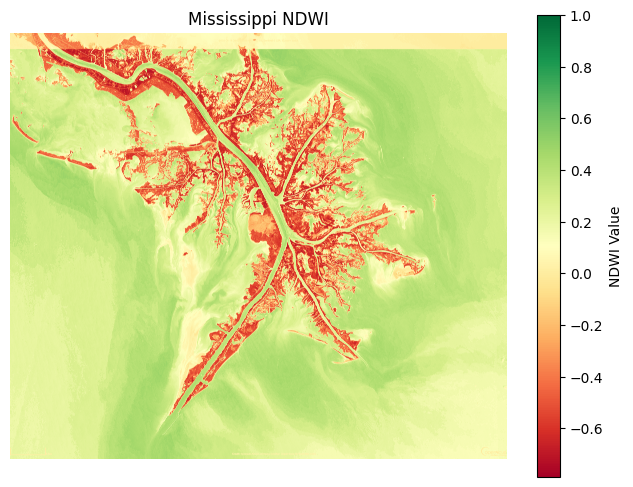

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Function to calculate NDWI (Normalized Difference Water Index)
def calculate_ndwi(green_band, nir_band):
    """
    Calculate NDWI using the green and NIR bands.
    NDWI = (Green - NIR) / (Green + NIR)
    """
    ndwi = (green_band - nir_band) / (green_band + nir_band + 1e-6)
    return ndwi

#  Mississippi NDWI Calculation
Mississippi_image_path = '/content/drive/MyDrive/AL4EO/final /Mississipi bands/2025-04-11-00_00_2025-04-11-23_59_Sentinel-2_L2A_Custom_script-2.jpg'

with rasterio.open(Mississippi_image_path) as src:
    Mississippi_image = src.read().astype(np.float32)
    Mississippi_green = Mississippi_image[0, :, :]  # B03 (Green)
    Mississippi_nir = Mississippi_image[2, :, :]    # B08 (NIR)

Mississippi_ndwi = calculate_ndwi(Mississippi_green, Mississippi_nir)

#  Plotting NDWI for Mississippi
plt.figure(figsize=(8, 6))
plt.title("Mississippi NDWI")
plt.imshow(Mississippi_ndwi, cmap='RdYlGn')
plt.colorbar(label="NDWI Value")
plt.axis('off')
plt.show()

The same is done for the Patagonia image

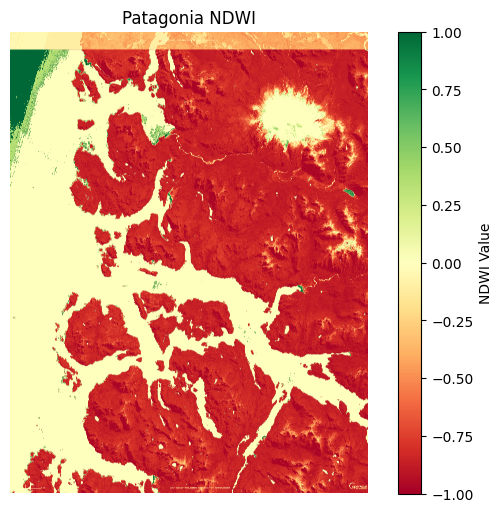

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

#  NDWI Calculation Function (Directly Defined Here)
def calculate_ndwi(green_band, nir_band):
    """
    Calculate NDWI using the green and NIR bands.
    NDWI = (Green - NIR) / (Green + NIR)
    """
    ndwi = (green_band - nir_band) / (green_band + nir_band + 1e-6)
    return ndwi

#  Patagonia NDWI Calculation
Patagonia_image_path = '/content/drive/MyDrive/AL4EO/final /south chilean patagonia bands/2025-04-06-00_00_2025-04-06-23_59_Sentinel-2_L2A_Custom_script.jpg'

with rasterio.open(Patagonia_image_path) as src:
    Patagonia_image = src.read().astype(np.float32)
    Patagonia_green = Patagonia_image[0, :, :]  # B03 (Green)
    Patagonia_nir = Patagonia_image[2, :, :]    # B08 (NIR)

#  Calculate NDWI
Patagonia_ndwi = calculate_ndwi(Patagonia_green, Patagonia_nir)

#  Plotting NDWI for Patagonia
plt.figure(figsize=(8, 6))
plt.title("Patagonia NDWI")
plt.imshow(Patagonia_ndwi, cmap='RdYlGn')
plt.colorbar(label="NDWI Value")
plt.axis('off')
plt.show()


## Spectral Water Index (SWI) Calculation and Water Mask Creation

The Spectral Water Index (SWI) is used to detect water bodies in satellite images using Sentinel-2 bands, specifically Band 5 (Red Edge) and Band 11 (Short-Wave Infrared). This index leverages the contrasting reflectance properties of water in these bands.



The SWI formula enhances the detection of water bodies by highlighting areas with lower reflectance in SWIR but higher reflectance in the Red Edge. A binary mask is created by applying a threshold (SWI > 0), isolating water regions for analysis. This method is applied to the Mississippi and Patagonia regions to visualize and compare water body distribution in diverse settings.


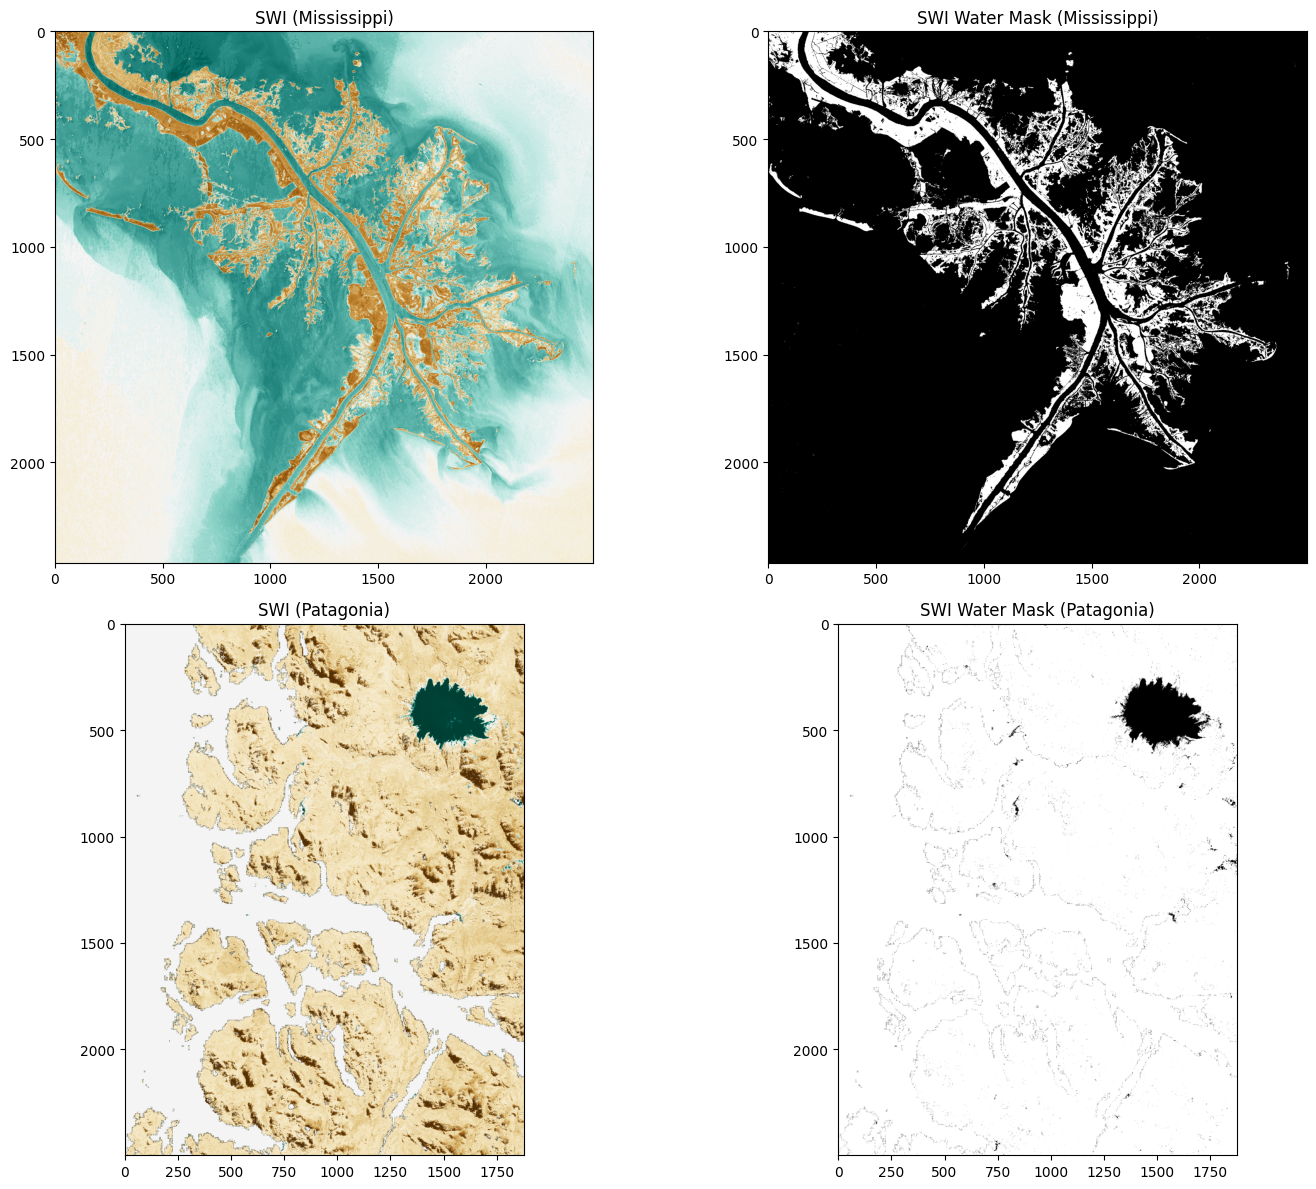

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate SWI
def calculate_swi(b5, b11):
    swi = (b5 - b11) / (b5 + b11 + 1e-6)
    return swi

# Load Band 5 and Band 11 for both Mississippi and Patagonia
def load_bands(band5_path, band11_path):
    with rasterio.open(band5_path) as b5, rasterio.open(band11_path) as b11:
        band5 = b5.read(1).astype(np.float32)
        band11 = b11.read(1).astype(np.float32)
    return band5, band11


mississippi_b5_path = "/content/drive/MyDrive/AL4EO/final /SWI mississippi /2025-04-11-00:00_2025-04-11-23:59_Sentinel-2_L2A_B05_(Raw).jpg"
mississippi_b11_path = "/content/drive/MyDrive/AL4EO/final /SWI mississippi /2025-04-11-00:00_2025-04-11-23:59_Sentinel-2_L2A_B11_(Raw).jpg"
patagonia_b5_path = "/content/drive/MyDrive/AL4EO/final /SWI patagonia/2025-04-06-00:00_2025-04-06-23:59_Sentinel-2_L2A_B05_(Raw).jpg"
patagonia_b11_path = "/content/drive/MyDrive/AL4EO/final /SWI patagonia/2025-04-06-00:00_2025-04-06-23:59_Sentinel-2_L2A_B11_(Raw).jpg"

# Load bands
mississippi_b5, mississippi_b11 = load_bands(mississippi_b5_path, mississippi_b11_path)
patagonia_b5, patagonia_b11 = load_bands(patagonia_b5_path, patagonia_b11_path)

# Calculate SWI
mississippi_swi = calculate_swi(mississippi_b5, mississippi_b11)
patagonia_swi = calculate_swi(patagonia_b5, patagonia_b11)

# Create binary water mask (SWI > 0)
mississippi_swi_mask = (mississippi_swi > 0).astype(np.uint8)
patagonia_swi_mask = (patagonia_swi > 0).astype(np.uint8)


fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Mississippi SWI and Mask
axs[0, 0].imshow(mississippi_swi, cmap='BrBG')
axs[0, 0].set_title("SWI (Mississippi)")
axs[0, 1].imshow(mississippi_swi_mask, cmap='binary')
axs[0, 1].set_title("SWI Water Mask (Mississippi)")

# Patagonia SWI and Mask
axs[1, 0].imshow(patagonia_swi, cmap='BrBG')
axs[1, 0].set_title("SWI (Patagonia)")
axs[1, 1].imshow(patagonia_swi_mask, cmap='binary')
axs[1, 1].set_title("SWI Water Mask (Patagonia)")

plt.tight_layout()
plt.show()

### Interpreting the SWI and Water Mask Images

- **SWI Image (Left):**
  - The SWI image visually highlights water bodies in shades of blue and non-water areas in shades of orange/brown.
  - Water bodies have high SWI values (blue), while land has lower values (orange).
  - This provides an intuitive visual understanding of water distribution.

- **SWI Water Mask (Right):**
  - The binary mask isolates water regions (white) from non-water regions (black).
  - This mask is a direct result of thresholding the SWI (values > 0), making it clear which areas are identified as water.
  - The mask is crucial for water body classification and segmentation, directly contributing to the primary goal of this project — comparing and analyzing water body distribution in two contrasting regions.


   These images are essential because they allow for a consistent and automated method to detect water bodies across both regions. By applying the same thresholding method to both regions, we ensure a fair and standardized comparison.


In [9]:
from sklearn.cluster import KMeans
import numpy as np
import rasterio


def apply_kmeans(scaled_data, shape, k):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(scaled_data)
    return labels.reshape(shape)


Mississippi_image_path = '/content/drive/MyDrive/AL4EO/final /2025-04-11-00_00_2025-04-11-23_59_Sentinel-2_L2A_True_color.jpg'
Patagonia_image_path = '/content/drive/MyDrive/AL4EO/final /2025-04-06-00_00_2025-04-06-23_59_Sentinel-2_L2A_True_color-2.jpg'

# Load and scale the images (normalize to 0-1)
with rasterio.open(Mississippi_image_path) as src:
    Mississippi_image = src.read()  # (bands, height, width)
    Mississippi_scaled = Mississippi_image.reshape(Mississippi_image.shape[0], -1).T / 255.0
    Mississippi_shape = (src.height, src.width)

with rasterio.open(Patagonia_image_path) as src:
    Patagonia_image = src.read()
    Patagonia_scaled = Patagonia_image.reshape(Patagonia_image.shape[0], -1).T / 255.0
    Patagonia_shape = (src.height, src.width)

# Applying K-Means with Automatic Shape Detection
Mississippi_kmeans = apply_kmeans(Mississippi_scaled, Mississippi_shape, k=4)
Patagonia_kmeans = apply_kmeans(Patagonia_scaled, Patagonia_shape, k=4)

print("Mississippi K-Means Shape:", Mississippi_kmeans.shape)
print("Patagonia K-Means Shape:", Patagonia_kmeans.shape)


Mississippi K-Means Shape: (2149, 2500)
Patagonia K-Means Shape: (2500, 1932)


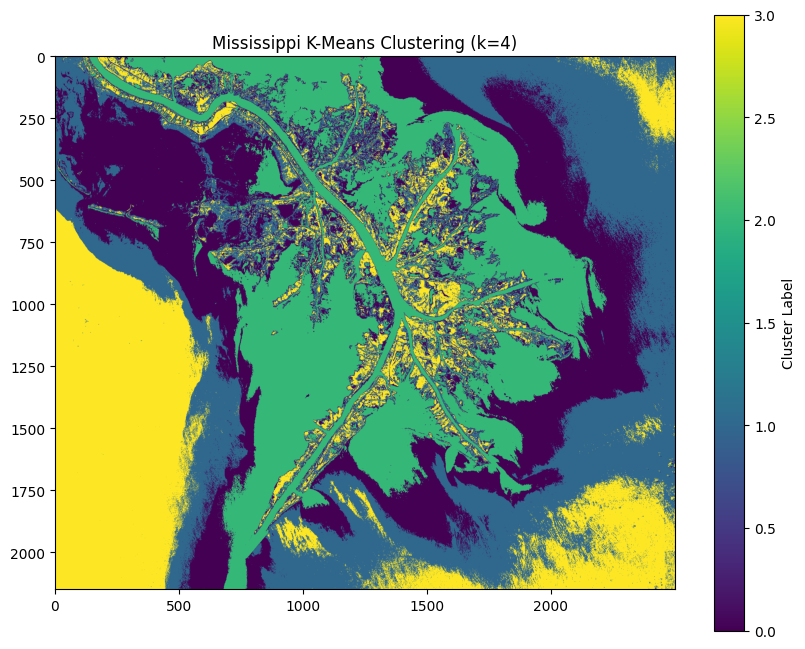

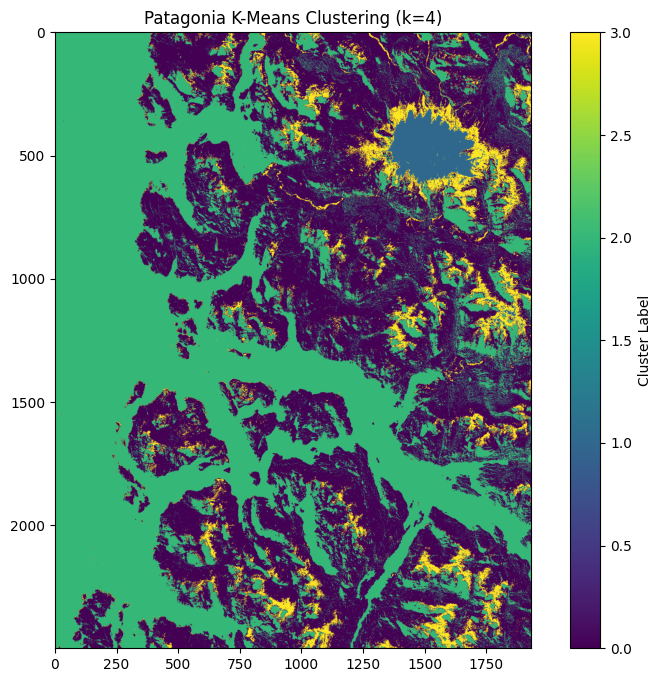

In [10]:
import matplotlib.pyplot as plt

# Visualizing the Mississippi K-means clustering
plt.figure(figsize=(10, 8))
plt.title("Mississippi K-Means Clustering (k=4)")
plt.imshow(Mississippi_kmeans, cmap='viridis')
plt.colorbar(label='Cluster Label')
plt.show()

# Visualizing the Patagonia K-means clustering
plt.figure(figsize=(10, 8))
plt.title("Patagonia K-Means Clustering (k=4)")
plt.imshow(Patagonia_kmeans, cmap='viridis')
plt.colorbar(label='Cluster Label')
plt.show()


## K-Means Clustering of Land Cover

This section applies K-means clustering to segment the Mississippi and Patagonia regions using spectral data. The Sentinel-2 images are loaded and normalized for processing. The K-means algorithm is applied to classify the image pixels into distinct land cover types.

The `apply_kmeans` function initializes and fits the K-means model using the specified number of clusters (k). The resulting cluster labels are reshaped to match the original image dimensions for clear visualization.

The Mississippi and Patagonia images are loaded using the specified file paths. Each image is normalized to a range of 0-1 for accurate clustering. The images are then reshaped to a 2D format suitable for K-means processing.

After clustering, the results are displayed for both regions, allowing for a clear comparison of the segmentation achieved at different k values.


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


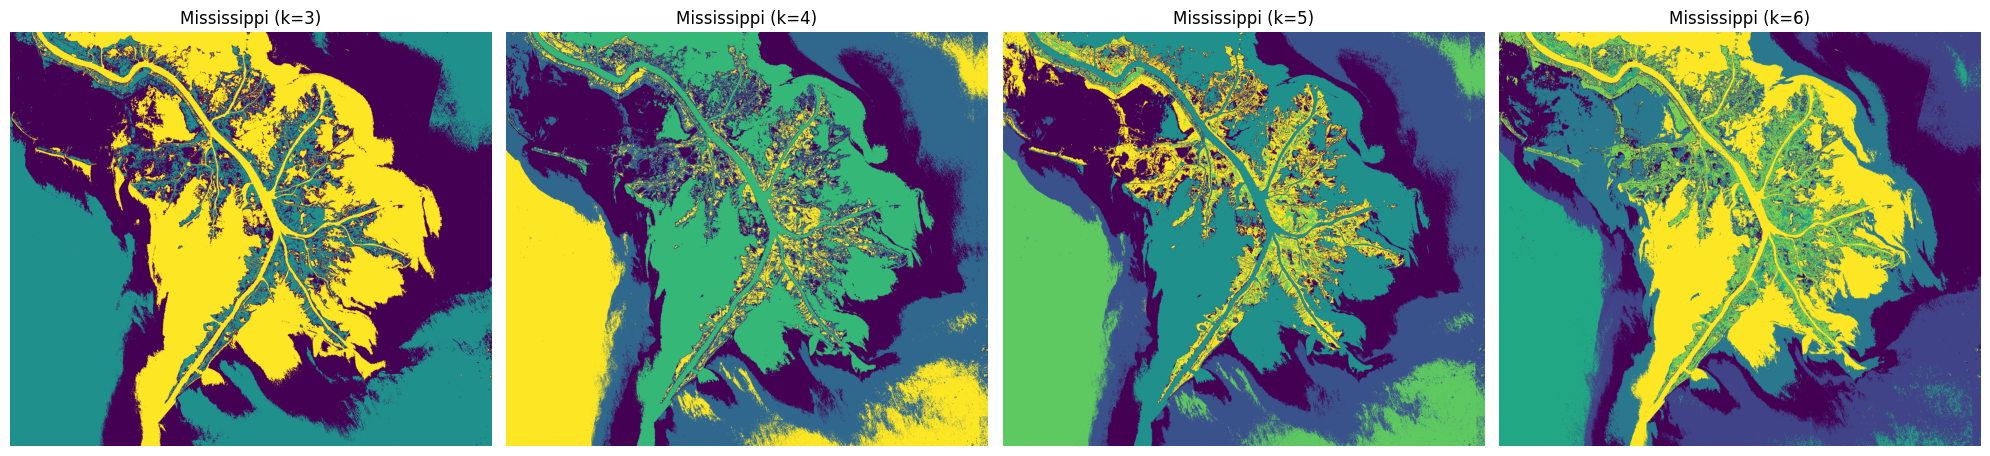

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


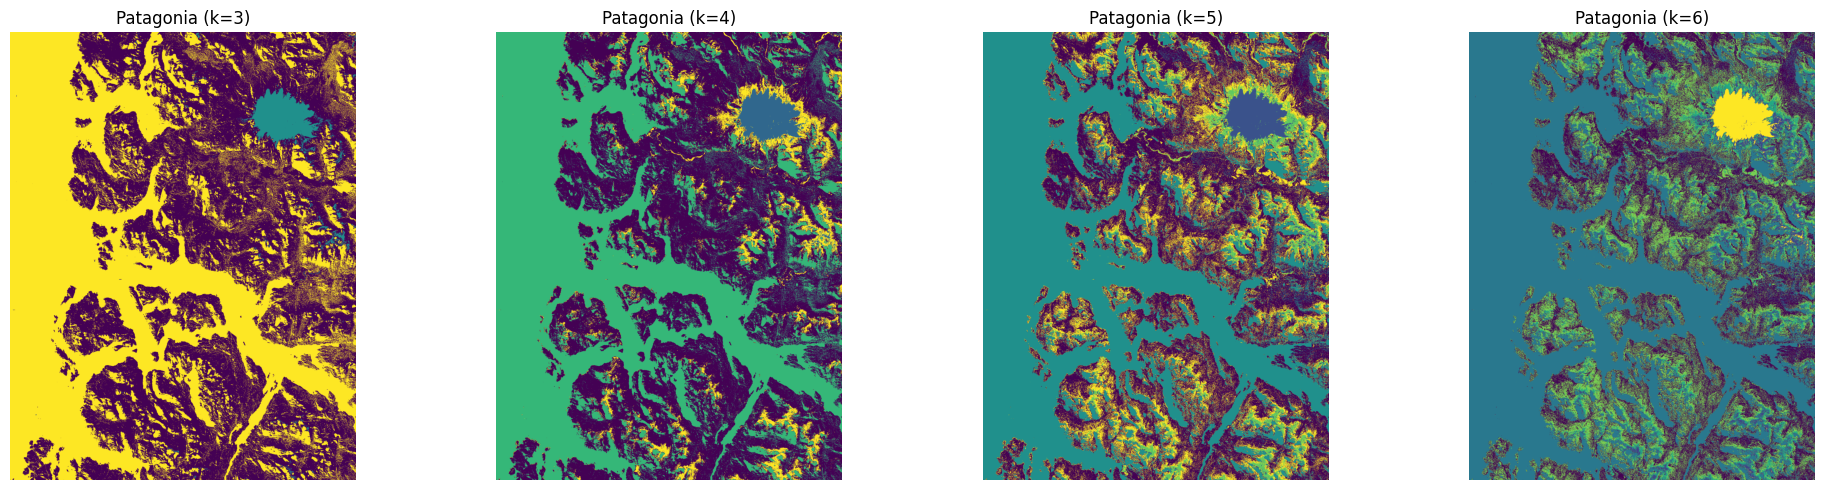

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import rasterio

# Load the Sentinel-2 images
mississippi_path = '/content/drive/MyDrive/AL4EO/final /2025-04-11-00_00_2025-04-11-23_59_Sentinel-2_L2A_True_color.jpg'
patagonia_path = '/content/drive/MyDrive/AL4EO/final /2025-04-06-00_00_2025-04-06-23_59_Sentinel-2_L2A_True_color-2.jpg'

# Function to process and cluster each image
def process_and_cluster(image_path, region_name, k_values=[3, 4, 5, 6]):
    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3])  # RGB Bands (Red, Green, Blue)

    # Normalize image
    image = image / 255.0
    image_reshaped = image.transpose(1, 2, 0).reshape(-1, 3)

    # Cluster and visualize
    fig, axes = plt.subplots(1, len(k_values), figsize=(20, 5))
    for i, k in enumerate(k_values):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(image_reshaped)
        clustered_image = labels.reshape(image.shape[1], image.shape[2])

        axes[i].imshow(clustered_image, cmap='viridis')
        axes[i].set_title(f'{region_name} (k={k})')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Process and display both images
process_and_cluster(mississippi_path, 'Mississippi')
process_and_cluster(patagonia_path, 'Patagonia')


## K-Means Clustering Comparison: Mississippi and Patagonia

This figure demonstrates the impact of changing the number of clusters \( k \) in K-means clustering for two contrasting regions: Mississippi and Patagonia. The objective of this comparison is to explore how increasing the number of clusters affects the classification of land cover types in each area.

In Mississippi, K-means clustering with \( k = 3 \) produces a broad classification, effectively separating water, vegetation, and land surfaces. As the value of \( k \) increases to 4, 5, and 6, the classification becomes more detailed. Additional clusters allow for finer distinctions, such as separating dense vegetation from sparse areas and distinguishing different water regions. However, excessively high \( k \) values may lead to over-segmentation, where regions are divided into too many small, fragmented clusters.

In Patagonia, a similar pattern is observed. At \( k = 3 \), the clustering captures major landscape features, including water bodies and mountainous areas. As \( k \) increases, more specific details emerge, such as variations in vegetation density and isolated water features. This progressive refinement demonstrates how K-means clustering can capture subtle differences in land cover, but may also lead to noisy results if \( k \) is too high.

This comparison shows the importance of selecting an appropriate \( k \) value based on the complexity of the region being analyzed. While higher \( k \) values provide more detail, they can also result in over-segmentation, which may reduce the clarity of the final classification.



## Project Conclusion

This project effectively tackled the challenge of unsupervised land cover classification using Sentinel-2 imagery across two contrasting regions: the Mississippi Delta and Patagonia. The classification process combined NDVI for vegetation detection, NDWI for water body identification, and SWI for enhanced water mapping, all processed through K-means clustering. This approach demonstrated strong performance in the Mississippi Delta, where clear distinctions between water and vegetation led to accurate classification. In contrast, the complex landscape of Patagonia posed challenges, with some misclassification in areas of mixed moisture conditions.

The workflow offers a scalable solution for land cover classification, adaptable to diverse geographic regions. Its strengths lie in effectively distinguishing well-defined land cover types, but limitations are evident in more heterogeneous landscapes where unsupervised clustering struggles with mixed pixels. Future improvements could include the integration of additional spectral indices, more advanced clustering methods, or the use of hybrid models that combine supervised and unsupervised techniques to enhance classification accuracy.In summary, this project demonstrates the potential of unsupervised land cover classification using Sentinel-2 imagery, offering a scalable approach for environmental monitoring, while highlighting the importance of adapting methods to suit the complexity of different landscapes.




